# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
# Upgrade pandas and numpy
!pip install --upgrade pandas
!pip install --upgrade numpy

Requirement already up-to-date: pandas in /opt/conda/lib/python3.6/site-packages (1.1.5)
Requirement already up-to-date: numpy in /opt/conda/lib/python3.6/site-packages (1.19.5)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show versions
print(pd.__version__)
print(np.__version__)

1.1.5
1.19.5


In [3]:
# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [4]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [5]:
# How many articles did each user interact with?
article_interactions = df.groupby(by=['email'])[['article_id']].count().rename(columns={'article_id':'article_interactions'}).sort_values(by=['article_interactions'], ascending=False)
article_interactions.head(10)

,article_interactions
email,
2b6c0f514c2f2b04ad3c4583407dccd0810469ee,364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a,363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66,170
a37adec71b667b297ed2440a9ff7dad427c7ac85,169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93,160
f8c978bcf2ae2fb8885814a9b85ffef2f54c3c76,158
284d0c17905de71e209b376e3309c0b08134f7e2,148
18e7255ee311d4bd78f5993a9f09538e459e3fcc,147
d9032ff68d0fd45dfd18c0c5f7324619bb55362c,147


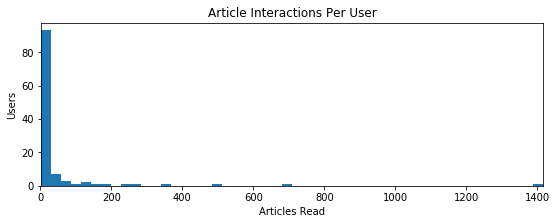

In [6]:
# Plot Histogram
fig = plt.figure(figsize=(9,3))
x = article_interactions['article_interactions'].value_counts()
plt.hist(x, bins=50)
plt.xlim([x.min(), x.max()])
plt.gca().set(title='Article Interactions Per User', ylabel='Users', xlabel='Articles Read');

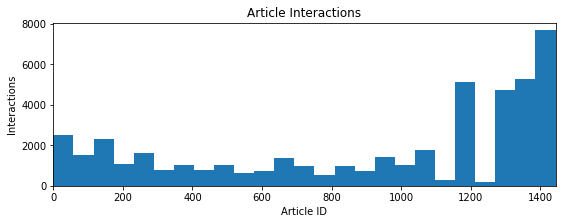

In [7]:
# Plot Histogram for article popularity
fig = plt.figure(figsize=(9,3))
x = df['article_id']
plt.hist(x, bins=25)
plt.xlim([x.min(), x.max()])
plt.gca().set(title='Article Interactions', ylabel='Interactions', xlabel='Article ID');

In [8]:
# Plot most interacted articles
n = 10
print('Top 10 Articles')
df['article_id'].value_counts().nlargest(n)

Top 10 Articles


1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
1314.0    614
1293.0    572
1170.0    565
1162.0    512
1304.0    483
Name: article_id, dtype: int64

In [9]:
# Fill in the median and maximum number of user_article interactios below
median_val = np.median(article_interactions['article_interactions']) # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = np.max(article_interactions['article_interactions']) # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [10]:
# Find and explore duplicate articles
print('Duplicates before:', df_content['article_id'].duplicated().sum())

Duplicates before: 5


In [11]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates('article_id')
print('Duplicates after:', df_content.duplicated().sum())

Duplicates after: 0


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [12]:
# a. The number of unique articles that have an interaction with a user.
df['article_id'].nunique()

714

In [13]:
# b. The number of unique articles in the dataset (whether they have any interactions or not).
df_content['article_id'].nunique()

1051

In [14]:
# c. The number of unique users in the dataset. (excluding null values)
df['email'].nunique()

5148

In [15]:
# d. The number of user-article interactions in the dataset.
df['article_id'].count()

45993

In [16]:
# Median interactions
np.median(article_interactions['article_interactions'])

3.0

In [17]:
# Maximum interactions
np.max(article_interactions['article_interactions'])

364

In [18]:
unique_articles = df['article_id'].nunique() # The number of unique articles that have at least one interaction
total_articles = df_content['article_id'].nunique() # The number of unique articles on the IBM platform
unique_users = df['email'].nunique() # The number of unique users
user_article_interactions = df['article_id'].count() # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [19]:
# Most viewed article_id
df['article_id'].value_counts().nlargest(1)

In [20]:
# Article_id as a string
mva = df['article_id'].value_counts().nlargest(1).index.tolist()
mva

In [ ]:
# Article max views
mv = df['article_id'].value_counts().nlargest(1).tolist()
mv

In [ ]:
# Unique user ids
unique_users

In [ ]:
most_viewed_article_id = str(mva[0]) # The most viewed article in the dataset as a string with one value following the decimal 
max_views = mv[0] # The most viewed article in the dataset was viewed how many times?

In [ ]:
# Max views
max_views

In [ ]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

In [ ]:
most_viewed_article_id

In [ ]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

In [ ]:
sol_1_dict

### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [ ]:
# test the grouping top 1 article by title
test_top_articles = list(df['title'].value_counts().head(1).index)
test_top_articles

In [ ]:
# test the grouping top 1 article by id
list(map(str, df['article_id'].value_counts().head(1).index))

In [ ]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # grouping top n articles by title
    top_articles = list(df['title'].value_counts().head(n).index)
    
    return top_articles # Return the top article titles from df

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # grouping top n articles
    top_article_ids = list(map(str, df['article_id'].value_counts().head(n).index))
    
    return top_article_ids # Return the top article ids

In [ ]:
get_top_articles(10), get_top_article_ids(10)

In [ ]:
type(get_top_article_ids(1)[0])

In [ ]:
df[:10]

In [ ]:
print(get_top_articles(10))
print(get_top_article_ids(10))

In [ ]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [ ]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # # Drop duplicates to count only unique interactions
    df = df.drop_duplicates(subset=['user_id', 'article_id']) 
    
    # Creating the user_item matrix 
    user_item = df.groupby(['user_id', 'article_id']).count().unstack()
    
    return user_item # return the user_item matrix and fillna

user_item = create_user_item_matrix(df)

In [ ]:
# fillna user_item
user_item = user_item.fillna(0)

In [ ]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [ ]:
# creating a test user id
test_user_id = 1

In [ ]:
# testing transposing similarity of a sample of users
sim_test = user_item[user_item.index == test_user_id].dot(np.transpose(user_item))
sim_test

In [ ]:
# testing sorting values
sim_test = sim_test.sort_values(by=test_user_id, axis=1, ascending=False)
sim_test

In [ ]:
# drop own user id column
sim_test = sim_test.drop(columns=test_user_id)
sim_test

In [ ]:
# testing converting ids to a list inside a np.array
msu_test = np.array(sim_test.columns.tolist())
msu_test

In [ ]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each provided user with other users
    similarity = user_item[user_item.index == user_id].dot(np.transpose(user_item))
    
    # sorting the similarity values
    similarity = similarity.sort_values(by=user_id, axis=1, ascending=False)
    
    # drop own user id column
    similarity = similarity.drop(columns=user_id)
    
    # converting ids to a list inside a np.array
    most_similar_users = np.array(similarity.columns.tolist())
    
    # return a list of the users in order from most to least similar
    return most_similar_users

In [ ]:
# testing output
find_similar_users(1, user_item=user_item)

In [ ]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [ ]:
df.head()

In [ ]:
# get_article_names: extract a test article list
list(df['article_id'][:5])

In [ ]:
# change test_user_id
test_user_id = 20

In [ ]:
# get_article_names: testing get_article_names
article_ids_test = list(df['article_id'][:5])

for article in article_ids_test:
    print(df[df['article_id'] == float(article)].max()['title'])

In [ ]:
# get_article_names: testing appending titles to list
article_names_test = []

for article in article_ids_test:
    article_title_test = df[df['article_id'] == float(article)].max()['title']
    article_names_test.append(article_title_test)
    
article_names_test

In [ ]:
# get_user_articles: filter article ids seen for user
user_item.loc[test_user_id][user_item.loc[test_user_id] > 0]

In [ ]:
# get_user_articles: create a list of article_ids seen for input user_id
article_ids_test = user_item.loc[test_user_id][user_item.loc[test_user_id] > 0].index.get_level_values(1)
article_ids_test

In [ ]:
# get_user_articles: convert list of int to strings
article_ids_test = [str(x) for x in article_ids_test] 
article_names_test = article_names_test

# printing first 5 results of each
print(article_ids_test[:5])
print(article_names_test[:5])

In [ ]:
# user_user_recs: create sample output limit
m_test = 10

# create an empty np.array and one with similar user ids
recs_test = np.array([])
similar_users_test = find_similar_users(test_user_id)

In [ ]:
# user_user_recs: loop through similar_users_test to get a list of recommendations
for s_user in similar_users_test:
    article_ids_test, article_names_test
    recs_test = np.append(recs_test, article_ids_test)
    if len(recs_test) >= m_test:
        break
        
# show output        
recs_test[:m_test]

In [ ]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # get article names
    article_names = []
    for article in article_ids:
        article_title = df[df['article_id'] == float(article)].max()['title']
        article_names.append(article_title)
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # create a list of article_ids seen for input user_id
    article_ids = user_item.loc[user_id][user_item.loc[user_id] > 0].index.get_level_values(1)
    
    # convert list of int to strings
    article_ids = [str(x) for x in article_ids] 
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # create empty np.array
    recs = np.array([])
    
    # create an array with similar user ids
    similar_users = find_similar_users(user_id)
    
    # get recommendations
    for s_user in similar_users:
        article_ids, article_names = get_user_articles(s_user)
        recs = np.append(recs, article_ids)
        if len(recs) >= m:
            break
    
    return recs[:m] # return your recommendations for this user_id    

In [ ]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

In [ ]:
user_user_recs(1, 10)

In [ ]:
user_item.loc[1][user_item.loc[1].notnull()].index.get_level_values(1).sort_values(ascending=False)

In [ ]:
# Check Results
get_user_articles(5) # Return user articles

In [ ]:
set(get_user_articles(20)[1])

In [ ]:
get_user_articles(2)[0]

In [ ]:
get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])

In [ ]:
get_user_articles(20)[0]

In [ ]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [ ]:
user_item.info()

In [ ]:
user_item['title'].dtypes.unique()

In [ ]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # create vector for input user
    find_user = user_item.loc[user_id]
    
    # create vector using dot product of user_item matrix with find_user variable
    similarity = np.dot(user_item, find_user) 
    
    # sort similarity by using the reversed index in 'sort_ids'
    sort_ids = np.argsort(similarity)[::-1]
    
    # reverse sort using np.sort as 'similarity'
    similarity = np.sort(similarity)[::-1]
    
    # sort user ids by resetting index
    sort_uids = user_item.iloc[sort_ids].index
    
    # finding the number of user_item interactions per user by reindexing
    interactions = user_item.reindex(sort_uids).sum(axis=1).values
    
    # creating a neighbors_df with neighbour_ids, similarity and, interactions
    neighbors_df = pd.DataFrame({'neighbor_id':sort_uids.values,
                                 'similarity':similarity,
                                 'num_interactions':interactions})
    
    # remove the own user's id then sort
    neighbors_df = neighbors_df[neighbors_df['neighbor_id'] != user_id]\
    .sort_values(['similarity','num_interactions'], ascending = False)
    
    return neighbors_df # return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # create empty np.array
    recs = np.array([])

    # article ids and names seen
    article_ids_seen, article_names_seen = get_user_articles(user_id)

    # sort neighbours_df by similarity and total interactions per user
    neighbors_df = get_top_sorted_users(user_id)
    #neighbors_df['neighbor_id'] = neighbors_df['neighbor_id'].astype(float)

    # loop for each similar user to break if length is greater than n recs requested
    for user in neighbors_df['neighbor_id']:
        if len(recs) >= m:
            break

        # collect article ids and names of each similar user
        article_ids, article_names = get_user_articles(user)

        # sort article_ids by most interactions
        article_ids = list(map(np.float64, article_ids))
        sorted_article_ids = user_item['title'][article_ids].sum().sort_values(ascending = False).index

        # append recs to array then remove articles the user has seen
        recs = np.append(recs, sorted_article_ids).astype(str)
        recs = recs[~np.isin(recs, article_ids_seen)][:m]

    rec_names = get_article_names(recs)[:m]
    return recs, rec_names

In [ ]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [ ]:
get_top_sorted_users(1),df['user_id'].iloc[0]

In [ ]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).iloc[0][0].astype(int) # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).iloc[10][0].astype(int) # Find the 10th most similar user to user 131

In [ ]:
print('user1_most_sim:', user1_most_sim, 'type:', type(user1_most_sim))
print('user131_10th_sim:', user131_10th_sim, 'type:', type(user131_10th_sim))

In [ ]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Answer:** We could use `get_top_articles` and `get_top_article_ids` to recommend the top articles if we have no previous data on a new user. We won't be able to use Collaborative Filtering recommendations if the user has no observed articles because it requires data on articles a user has seen to make recommendations from other similar users. This problem is known as 'The Cold Start Problem'.

The best method to use in this case is to provide new users with Knowledge-based recommendations. This allows us to simply recommend the most popular articles to the user without having to know anything about them.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [ ]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10) # Your recommendations here

In [ ]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
df_content.head()

In [ ]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [ ]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [ ]:
print(user_item_matrix.shape)

In [ ]:
# quick look at the matrix
user_item_matrix.head()

`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [ ]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item.fillna(0), full_matrices=False) # use the built in to get the three matrices
print(u.shape, s.shape, vt.shape)

**Answer:**
By using SVD on our matrix, we can find latent features related to the articles and customers. This is great because the dataset doesn't contain much information about the customers or articles! However, it only works when the dataset has no missing values. However, we can fill the missing values with `0` when we need to make recommendations to a new user since the user has not seen any articles yet.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

In [ ]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [ ]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # 1. creating user item matrixes
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    # 2. masking users that are not part of our training set
    user_item_test = user_item_test[np.isin(user_item_test.index,user_item_train.index)]
    
    # 3. extracting the test user ids and article ids
    test_idx = user_item_test.index.values
    test_arts = user_item_test.columns.levels[1].values
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [ ]:
user_item_test.fillna(0).head()

In [ ]:
a = len(test_idx) # total entries in test_idx (test user ids)
b = df_test.nunique()[2] - len(test_idx) # unique user_ids - test_idx total entries
c = len(test_arts) # total entries in test_arts (test article ids)
d = df_test.nunique()[0] - len(test_arts) # unique article_ids - test_idx total entries

In [ ]:
print('How many users can we make predictions for in the test set?' , a) 
print('How many users in the test set are we not able to make predictions for because of the cold start problem? ', b) 
print('How many articles can we make predictions for in the test set? ', c)
print('How many articles in the test set are we not able to make predictions for because of the cold start problem? ', d)

In [ ]:
# Replace the values in the dictionary below
a = 662 
b = 574
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [ ]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train['title'][test_arts].fillna(0), full_matrices=False) # use the built in to get the three matrices
print(u_train.shape, s_train.shape, vt_train.shape) # fit svd similar to above then use the cells below

In [ ]:
user_item.shape

In [ ]:
user_item_train.shape

In [ ]:
user_item_test.shape

In [ ]:
# using the training decomposition to predict on test data
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []
n = -1 # stops out of bounds error on u_train

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[test_idx+n, :k], vt_train[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_test, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
print('user_item_test shape: ', user_item_test.fillna(0).shape, '| user_item_est shape: ', user_item_est.shape)

In [ ]:
user_item_test.shape

In [ ]:
test_count_0 = user_item_test.fillna(0)[user_item_test.fillna(0) == 0.0].count().sum()
test_count_0

In [ ]:
test_count_1 = user_item_test[user_item_test == 1.0].count().sum()
test_count_1

In [ ]:
# total amount of results
test_count_0 + test_count_1

In [ ]:
# percentage of 1.0 results
test_count_1 / test_count_0

In [ ]:
train_count_0 = user_item_train.fillna(0)[user_item_train.fillna(0) == 0.0].count().sum()
train_count_0

In [ ]:
train_count_1 = user_item_train[user_item_train == 1.0].count().sum()
train_count_1

In [ ]:
# total amount of results
train_count_0 + train_count_1

In [ ]:
# percentage of 1.0 results
train_count_1 / train_count_0

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Answer A: What is my feedback on the results?**
1. The model accuracy of around 99% is very good but seems to decrease as we add more than 300 latent features. This could be down to the fact the test set has only 20 users.
2. Imbalance between the classes of 1's and 0's since 1.0 accounts for only 0.09% of the training dataset and 0.19% of the testing dataset.
3. The model could be overfitted which means our model will be good at fitting to the data we have, but bad at recommending new articles to users. This is because there is a lot of missing information in the `user_item_matrix`.

**Answer B: How can I determine if the current recommendation systems are an improvement to how users currently find articles?**

**Method 1: Offline evaluation**<br>

If we don't want to our recommendation engine to go live we can split our data into training and testing sets. We could train our recommendation engine on a portion of the data, then test and find more insights on the results of our recommendation system using **Recall** and **Precision** to evaluate the performance. 

**Method 2: Online evaluation**<br>

We could also deploy our recommendation engine online to see how current recommendations to users impact metrics such as **Engagement**, **Click-Through Rate (CTR)** and **Time Spent** on each article. Then, we can observe the metrics again after deploying our new recommendation engine to see the results. We could also split our online users into A/B test groups to observe the results that way. A good strategy would be to release 20% of users to the testing recommendation system and 80% to the normal system to keep disruption to a minimum.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])